ISMIR 2016 Tutorial  
Introduction to EEG Decoding  
for Music Information Retrieval Research  
  
# Part I - Pre-Processing
Sebastian Stober  
dataset: [https://github.com/sstober/openmiir](https://github.com/sstober/openmiir)  
software libs: mne-python, numpy, scipy, matplotlib.pyplot, scikit-learn (for ICA)

In [ ]:
# download the data for this notebook
def download(urls, target_path):
    import os
    import urllib
    
    if not os.path.exists(target_path):
        os.makedirs(target_path)
    
    for u in urls:
        filepath = os.path.join(target_path, u.split('/')[-1])
        if not os.path.exists(filepath):
            print 'downloading', u
            urllib.urlretrieve(u, filepath)
        else:
            print 'skipping', filepath

TODO: fix URLs
    OpenMIIR_P09-raw.fif
download(['https://stacks.stanford.edu/file/druid:js383fs8244/P1_preprocessed.mat',
          'https://stacks.stanford.edu/file/druid:js383fs8244/P2_preprocessed.mat'],
         'data/')

In [2]:
verbose = True  # change this if you want less verbose output

import matplotlib
%matplotlib inline

import matplotlib.pyplot as plt
import numpy as np

import mne
mne.set_log_level('Info')

sfreq = 64 # down-sampling frequency (makes things a lot faster)
data_filepath = 'data/OpenMIIR_P09-raw.fif'

# Import or Load Raw

In [3]:
raw = mne.io.Raw(data_filepath, preload=True, verbose=verbose)

Opening raw data file /Users/sstober/work/code-repos/openmiir/eeg/mne/P09-raw.fif...
Isotrak not found
    Read a total of 1 projection items:
        Average EEG reference (1 x 66)  idle
    Range : 0 ... 2440555 =      0.000 ...  4766.709 secs
Ready.
Reading 0 ... 2440555  =      0.000 ...  4766.709 secs...


In [4]:
# all the meta-data stored in a raw
print raw.info

<Info | 18 non-empty fields
    bads : list | 0 items
    buffer_size_sec : numpy.float64 | 10.0
    ch_names : list | Fp1, AF7, AF3, F1, F3, F5, F7, FT7, FC5, FC3
    chs : list | 71 items (EEG: 66, STIM: 1, EOG: 4)
    comps : list | 0 items
    custom_ref_applied : bool | False
    events : list | 0 items
    file_id : dict | 4 items
    filename : str | /Users/sst.../P09-raw.fif
    highpass : float | 0.0 Hz
    hpi_meas : list | 0 items
    hpi_results : list | 0 items
    lowpass : float | 104.0 Hz
    meas_date : numpy.ndarray | 2015-02-25 18:18:34
    meas_id : dict | 4 items
    nchan : int | 71
    projs : list | Average EEG reference: off
    sfreq : float | 512.0 Hz
    acq_pars : NoneType
    acq_stim : NoneType
    ctf_head_t : NoneType
    description : NoneType
    dev_ctf_t : NoneType
    dev_head_t : NoneType
    dig : NoneType
    experimenter : NoneType
    hpi_subsystem : NoneType
    kit_system_id : NoneType
    line_freq : NoneType
    proj_id : NoneType
    proj

In [63]:
# Let's have a look at some channels
print raw.info['ch_names']

[u'Fp1', u'AF7', u'AF3', u'F1', u'F3', u'F5', u'F7', u'FT7', u'FC5', u'FC3', u'FC1', u'C1', u'C3', u'C5', u'T7', u'TP7', u'CP5', u'CP3', u'CP1', u'P1', u'P3', u'P5', u'P7', u'P9', u'PO7', u'PO3', u'O1', u'Iz', u'Oz', u'POz', u'Pz', u'CPz', u'Fpz', u'Fp2', u'AF8', u'AF4', u'AFz', u'Fz', u'F2', u'F4', u'F6', u'F8', u'FT8', u'FC6', u'FC4', u'FC2', u'FCz', u'Cz', u'C2', u'C4', u'C6', u'T8', u'TP8', u'CP6', u'CP4', u'CP2', u'P2', u'P4', u'P6', u'P8', u'P10', u'PO8', u'PO4', u'O2', u'EXG1', u'EXG2', u'EXG3', u'EXG4', u'STI 014']


In [5]:
# EOG channels: EXG1 - EXG4
# mastoid reference channels: EXG5 & EXG6
# trigger channel: STI 014
print
print 'EEG1:', raw.info['chs'][0]
print
print 'EOG1:', raw.info['chs'][64]
print
print 'REF1:', raw.info['chs'][-3]
print
print 'STIM:', raw.info['chs'][-1]

[u'Fp1', u'AF7', u'AF3', u'F1', u'F3', u'F5', u'F7', u'FT7', u'FC5', u'FC3', u'FC1', u'C1', u'C3', u'C5', u'T7', u'TP7', u'CP5', u'CP3', u'CP1', u'P1', u'P3', u'P5', u'P7', u'P9', u'PO7', u'PO3', u'O1', u'Iz', u'Oz', u'POz', u'Pz', u'CPz', u'Fpz', u'Fp2', u'AF8', u'AF4', u'AFz', u'Fz', u'F2', u'F4', u'F6', u'F8', u'FT8', u'FC6', u'FC4', u'FC2', u'FCz', u'Cz', u'C2', u'C4', u'C6', u'T8', u'TP8', u'CP6', u'CP4', u'CP2', u'P2', u'P4', u'P6', u'P8', u'P10', u'PO8', u'PO4', u'O2', u'EXG1', u'EXG2', u'EXG3', u'EXG4', u'EXG5', u'EXG6', u'STI 014']

EEG1: {'loc': array([-30.88287544,  95.04771423,  -3.4899497 ,   0.        ,
         0.        ,   0.        ,   0.        ,   0.        ,
         0.        ,   0.        ,   0.        ,   0.        ]), 'kind': 2, 'unit_mul': 0, 'ch_name': u'Fp1', 'range': 1.0, 'coord_frame': 4, 'logno': 1, 'cal': 16777215.0, 'coil_type': 1, 'scanno': 1, 'unit': 107}

EOG1: {'loc': array([ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.]), 'kind': 202, 

In [6]:
# apply mastoid reference and discard these channels
MASTOID_CHANNELS = [u'EXG5', u'EXG6']
mne.io.set_eeg_reference(raw, MASTOID_CHANNELS, copy=False) # inplace op
raw.drop_channels(MASTOID_CHANNELS)

Applying a custom EEG reference.
Removing existing average EEG reference projection.


<Raw  |  P09-raw.fif, n_channels x n_times : 69 x 2440556 (4766.7 sec), ~1.25 GB, data loaded>

# Reject Bad Channels

In [7]:
# switch to interactive GUI mode to scroll through data
%matplotlib tk
# scroll using cursor keys, click on channels to mark/unmark as "bad"
color = dict(eeg='blue',eog='red', stim='green')
raw.plot(n_channels=69, remove_dc=True, color=color);

/Users/sstober/.virtualenvs/ismir/lib/python2.7/site-packages/matplotlib/backend_managers.py:62: UserWarning: Treat the new Tool classes introduced in v1.5 as experimental for now, the API will likely change in version 2.1 and perhaps the rcParam as well
  'version 2.1 and perhaps the rcParam as well')
/Users/sstober/.virtualenvs/ismir/lib/python2.7/site-packages/matplotlib/backend_tools.py:78: UserWarning: Treat the new Tool classes introduced in v1.5 as experimental for now, the API will likely change in version 2.1, and some tools might change name
  'version 2.1, and some tools might change name')


In [8]:
# switch back to inline mode
%matplotlib inline

In [9]:
# print bad channels
raw.info['bads']

[]

In [10]:
# manually set bad channels
raw.info['bads'] = ['T8']

['__class__', '__delattr__', '__dict__', '__doc__', '__format__', '__getattribute__', '__hash__', '__init__', '__module__', '__new__', '__reduce__', '__reduce_ex__', '__repr__', '__setattr__', '__sizeof__', '__str__', '__subclasshook__', '__weakref__', 'box', 'ids', 'kind', 'names', 'plot', 'pos', 'save']


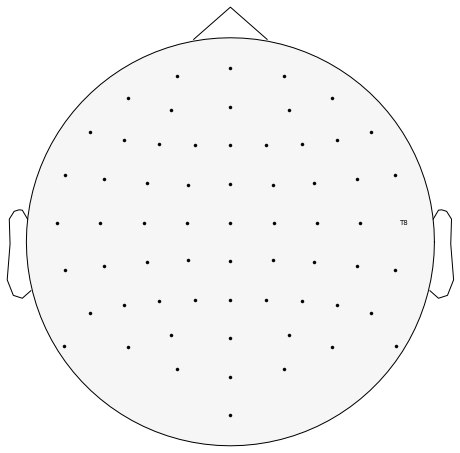

In [11]:
# Let's plot a topomap with the bad channel labels
bads = [raw.ch_names.index(ch) for ch in raw.info['bads']]
topo = raw[0:64,0][0].squeeze()

mask = np.zeros(64, dtype=bool)
mask[bads] = True
mask_params = dict(marker='', markeredgecolor='r', linewidth=0, markersize=4)

layout = mne.channels.read_layout('biosemi.lay')
print dir(layout)
pos = layout.pos

# print pos.shape
plt.figure(figsize=(8,8))
mne.viz.plot_topomap(topo, pos,
                     res=2,
                     sensors='k.',
                     names=layout.names,
                     show_names=True,
                     cmap='RdBu_r',
                     vmin=-1, vmax=1,
#                              vmin=vmin, vmax=vmax,
                     axes=plt.gca(),
                     contours=False,
                     mask=mask,
                     mask_params=mask_params
                 );

In [12]:
# intepolate bad channels
# This overwrites the channel data. To undo this, the raw data needs to be reloaded from file.
raw.interpolate_bads()

Computing interpolation matrix from 63 sensor positions
Interpolating 1 sensors


/Users/sstober/.virtualenvs/ismir/lib/python2.7/site-packages/scipy/linalg/basic.py:884: RuntimeWarning: internal gelsd driver lwork query error, required iwork dimension not returned. This is likely the result of LAPACK bug 0038, fixed in LAPACK 3.2.2 (released July 21, 2010). Falling back to 'gelss' driver.
  warnings.warn(mesg, RuntimeWarning)


<Raw  |  P09-raw.fif, n_channels x n_times : 69 x 2440556 (4766.7 sec), ~1.25 GB, data loaded>

In [13]:
# save EEG channels indices for later use
eeg_picks = mne.pick_types(raw.info, meg=False, eeg=True, eog=False, stim=False, exclude=[])
print eeg_picks

[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49
 50 51 52 53 54 55 56 57 58 59 60 61 62 63]


# Check and Merge Trials

540 events found
Events id: [  11   12   13   14   21   22   23   24   31   32   33   34   41   42   43
   44  111  112  113  114  121  122  123  124  131  132  133  134  141  142
  143  144  211  212  213  214  221  222  223  224  231  232  233  234  241
  242  243  244 1000 1111 2000 2001]
More events than colors available. You should pass a list of unique colors.


/Users/sstober/.virtualenvs/ismir/lib/python2.7/site-packages/ipykernel/__main__.py:3: RuntimeWarning: More events than colors available. You should pass a list of unique colors.
  app.launch_new_instance()


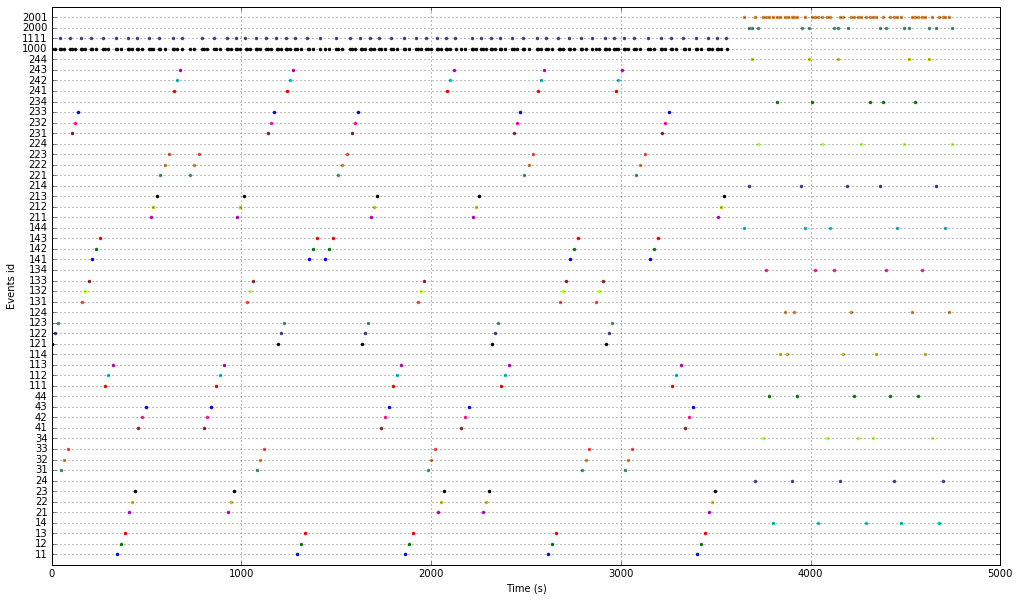

In [14]:
# It's always a good idea to do a sanity check with the event trigger recorded in the stim channel
trial_events = mne.find_events(raw, stim_channel='STI 014', shortest_event=0)
plt.figure(figsize=(17,10))
mne.viz.plot_events(trial_events, raw.info['sfreq'], raw.first_samp, axes=plt.gca());

In [15]:
# aux function compied from https://github.com/sstober/deepthought/blob/master/deepthought/datasets/openmiir/preprocessing/events.py
def merge_trial_and_audio_onsets(raw, use_audio_onsets=True, inplace=True, stim_channel='STI 014', verbose=None):
    events = mne.find_events(raw, stim_channel='STI 014', shortest_event=0)

    merged = list()
    last_trial_event = None
    for i, event in enumerate(events):
        etype = event[2]
        if etype < 1000 or etype == 1111: # trial or noise onset
            if use_audio_onsets and events[i+1][2] == 1000: # followed by audio onset
                onset = events[i+1][0]
                merged.append([onset, 0, etype])
                if verbose:
                    log.debug('merged {} + {} = {}'.format(event, events[i+1], merged[-1]))
            else:
                # either we are not interested in audio onsets or there is none
                merged.append(event)
                if verbose:
                    log.debug('kept {}'.format(merged[-1]))
        # audio onsets (etype == 1000) are not copied
        if etype > 1111: # other events (keystrokes)
            merged.append(event)
            if verbose:
                log.debug('kept other {}'.format(merged[-1]))

    merged = np.asarray(merged, dtype=int)

    if inplace:
        stim_id = raw.ch_names.index(stim_channel)
        raw._data[stim_id,:].fill(0)     # delete data in stim channel
        raw.add_events(merged)

    return merged
merge_trial_and_audio_onsets(raw, use_audio_onsets=True, inplace=True)

540 events found
Events id: [  11   12   13   14   21   22   23   24   31   32   33   34   41   42   43
   44  111  112  113  114  121  122  123  124  131  132  133  134  141  142
  143  144  211  212  213  214  221  222  223  224  231  232  233  234  241
  242  243  244 1000 1111 2000 2001]


array([[    522,       0,     121],
       [   8199,       0,     122],
       [  16568,       0,     123],
       ..., 
       [2422535,       0,    2001],
       [2430222,       0,     224],
       [2430315,       0,    2000]])

In [16]:
# an event is a 3-tuple (start, duration, type) with start and duration in samples
trial_events = mne.find_events(raw, stim_channel='STI 014', shortest_event=0)
print trial_events

360 events found
Events id: [  11   12   13   14   21   22   23   24   31   32   33   34   41   42   43
   44  111  112  113  114  121  122  123  124  131  132  133  134  141  142
  143  144  211  212  213  214  221  222  223  224  231  232  233  234  241
  242  243  244 1111 2000 2001]
[[    522       0     121]
 [   8199       0     122]
 [  16568       0     123]
 ..., 
 [2422535       0    2001]
 [2430222       0     224]
 [2430315       0    2000]]


# Check PSD and Channels

Effective window size : 4.000 (s)


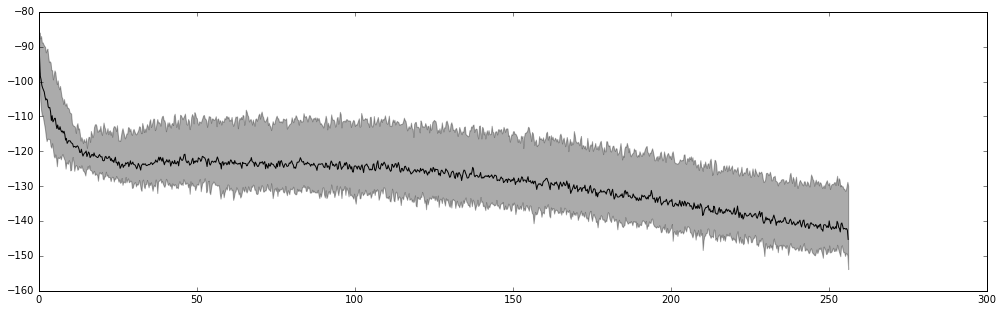

Effective window size : 4.000 (s)


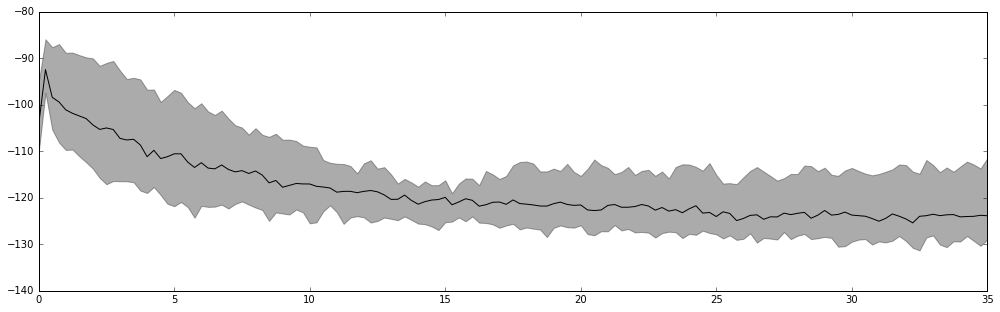

In [17]:
plt.figure(figsize=(17,5))
raw.plot_psd(area_mode='range', ax=plt.gca(), picks=eeg_picks, fmax=raw.info['sfreq'])
# line noise would be visible @ multiples of 60Hz
plt.figure(figsize=(17,5))
raw.plot_psd(area_mode='range', ax=plt.gca(), picks=eeg_picks, fmax=35);

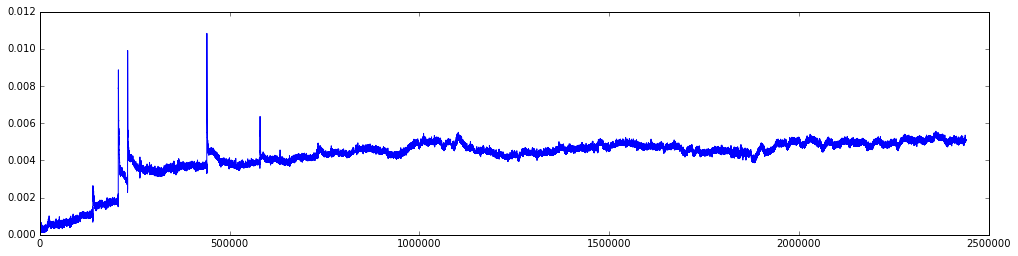

In [18]:
# plot a single channel
plt.figure(figsize=(17,4))
plt.plot(raw[0,:][0].squeeze())
# quite some drift and heavy movement (likely in the breaks)

# Bandpass Filtering

In [19]:
raw.filter(0.5, 30, picks=eeg_picks, filter_length='10s',
           l_trans_bandwidth=0.1, h_trans_bandwidth=0.5, method='fft',
           n_jobs=4, verbose=True)

Band-pass filtering from 0.5 - 30 Hz
phase in 0.13 is "zero-double" but will change to "zero" in 0.14


/Users/sstober/.virtualenvs/ismir/lib/python2.7/site-packages/ipykernel/__main__.py:3: DeprecationWarning: phase in 0.13 is "zero-double" but will change to "zero" in 0.14
  app.launch_new_instance()
[Parallel(n_jobs=4)]: Done  10 tasks      | elapsed:    3.6s
[Parallel(n_jobs=4)]: Done  64 out of  64 | elapsed:   17.0s finished


<Raw  |  P09-raw.fif, n_channels x n_times : 69 x 2440556 (4766.7 sec), ~1.25 GB, data loaded>

In [20]:
# plot the raw again. sometimes, it's now easier to spot bad channels
%matplotlib tk 
raw.plot();
pass

In [21]:
%matplotlib inline

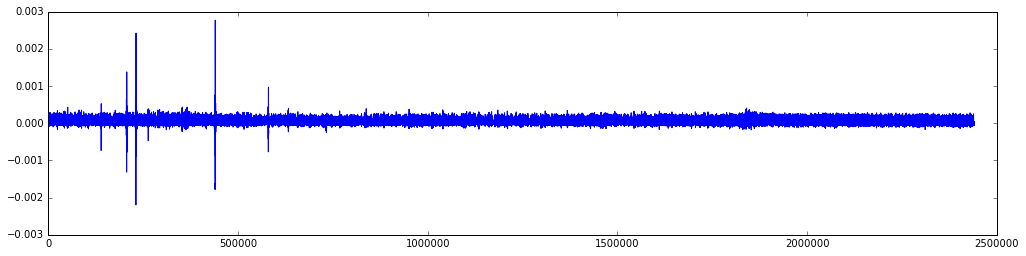

In [22]:
# plot a single again (same as earlier)
plt.figure(figsize=(17,4))
plt.plot(raw[0,:][0].squeeze())
# looks like we got rid of that drift - nice!

Effective window size : 4.000 (s)


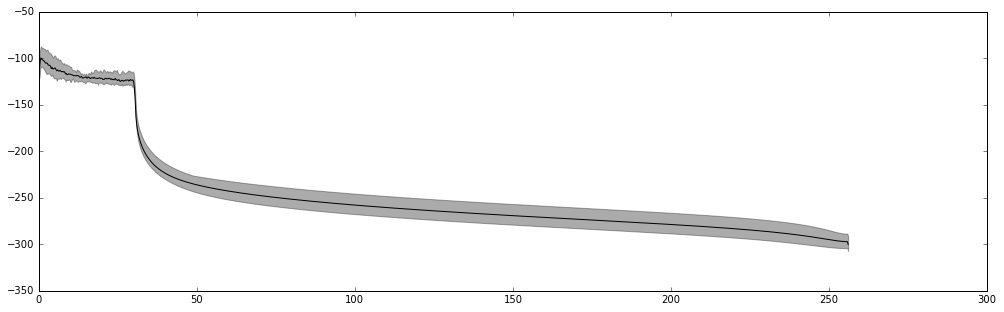

Effective window size : 4.000 (s)


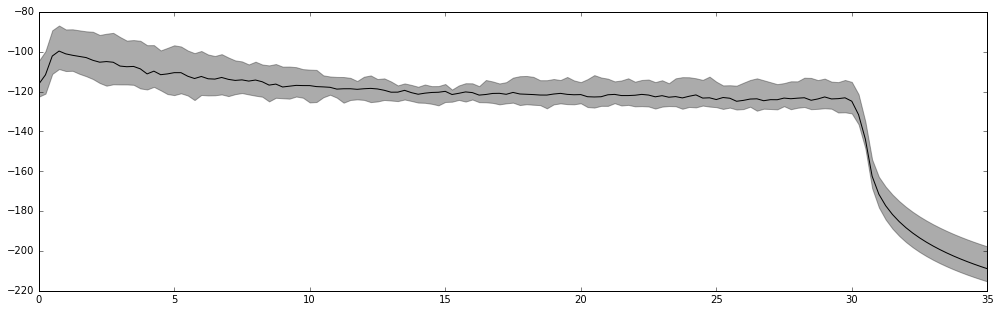

In [23]:
# the bandpass should have attenuated all out-of-band frequencies
plt.figure(figsize=(17,5))
raw.plot_psd(area_mode='range', ax=plt.gca(), picks=eeg_picks, fmax=raw.info['sfreq'])
# line noise would be visible @ multiples of 60Hz
plt.figure(figsize=(17,5))
raw.plot_psd(area_mode='range', ax=plt.gca(), picks=eeg_picks, fmax=35);

# Beat and EOG Epoching

EOG channel index for this subject is: [64 65 66 67]
Filtering the data to remove DC offset to help distinguish blinks from saccades
Now detecting blinks and generating corresponding events
Number of EOG events detected : 782


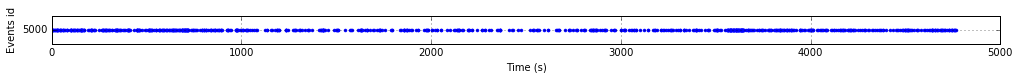

In [24]:
# check for EOG artifacts:
# NOTE: this should NOT be done after resampling because of reduced time resolution!
eog_event_id = 5000 # choose some new event ID for blinks
eog_events = mne.preprocessing.find_eog_events(raw, eog_event_id)

plt.figure(figsize=(17,0.5))
mne.viz.plot_events(eog_events, raw.info['sfreq'], raw.first_samp, axes=plt.gca())

# create epochs around EOG events
picks = mne.pick_types(raw.info, meg=False, eeg=True, eog=True, stim=True, exclude=[])
eog_epochs = mne.Epochs(raw, events=eog_events, event_id=eog_event_id,
                    tmin=-.5, tmax=.5, proj=False, picks=picks,
                    preload=True, verbose=False)

# wow - that's a lot of blinking

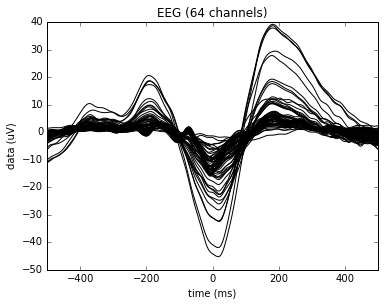

In [25]:
# plot the blink ERP
eog_evoked = eog_epochs.average()
eog_evoked.plot();

# Down-Sampling

In [26]:
# Since downsampling reduces the timing precision of events, we recommend
# first extracting epochs and downsampling the Epochs object:
raw = raw.resample(sfreq)

360 events found
Events id: [  11   12   13   14   21   22   23   24   31   32   33   34   41   42   43
   44  111  112  113  114  121  122  123  124  131  132  133  134  141  142
  143  144  211  212  213  214  221  222  223  224  231  232  233  234  241
  242  243  244 1111 2000 2001]
360 events found
Events id: [  11   12   13   14   21   22   23   24   31   32   33   34   41   42   43
   44  111  112  113  114  121  122  123  124  131  132  133  134  141  142
  143  144  211  212  213  214  221  222  223  224  231  232  233  234  241
  242  243  244 1111 2000 2001]


In [64]:
# note the change in the meta-data
print raw.info['sfreq']

64.0


In [65]:
eog_epochs = eog_epochs.resample(sfreq)
print eog_epochs.info['sfreq']

64.0


Effective window size : 32.000 (s)


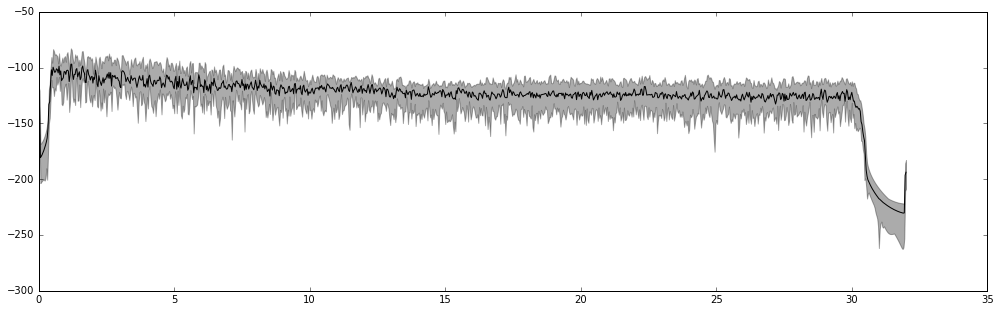

In [29]:
# check the PSD again
plt.figure(figsize=(17,5))
raw.plot_psd(area_mode='range', ax=plt.gca(), picks=eeg_picks, fmax=35);

# ICA

In [73]:
# only run this if not pre-computed
random_state = np.random.RandomState(42)
ica = mne.preprocessing.ICA(n_components=1.0, 
                            method='extended-infomax', 
                            random_state=random_state, 
                            verbose=True)
ica.fit(raw)

Fitting ICA to data using 63 channels. 
Please be patient, this may take some time
Inferring max_pca_components from picks.
Selection by explained variance: 63 components
computing Extended Infomax ICA


<ICA  |  raw data decomposition, fit (extended-infomax): 305070 samples, 63 components, channels used: "eeg">

In [74]:
# save ICA result for later
ica.save('data/P09-ica.fif')

Writing ica solution to data/P09-ica.fif...


<ICA  |  raw data decomposition, fit (extended-infomax): 305070 samples, 63 components, channels used: "eeg">

In [30]:
# load saved ICA object
ica = mne.preprocessing.read_ica('data/P09-ica.fif')

Reading data/P09-ica.fif ...
Isotrak not found
Now restoring ICA solution ...
Ready.


In [31]:
def resize(w=17, h=10):
    plt.gcf().set_size_inches(w, h, forward=True) # trick to increase size for show=False

Disabling interactive colorbar for multiple axes. Turn interactivity on explicitly by passing cmap as a tuple.


/Users/sstober/.virtualenvs/ismir/lib/python2.7/site-packages/ipykernel/__main__.py:2: RuntimeWarning: Disabling interactive colorbar for multiple axes. Turn interactivity on explicitly by passing cmap as a tuple.
  from ipykernel import kernelapp as app


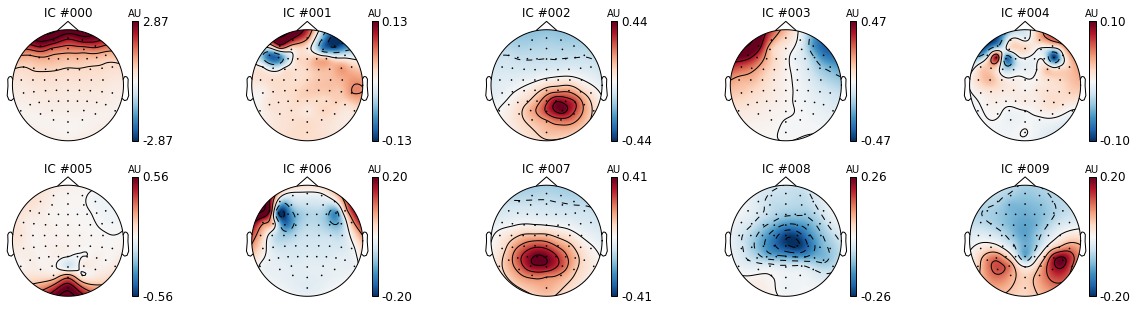

In [32]:
# plot top-10 ICs 
%matplotlib inline
ica.plot_components(picks=range(10), ch_type='eeg', title='', colorbar=True, show=False)
resize(17,5)

In [33]:
# auto-detect artifacts by simple statistics
ica.detect_artifacts(raw)

    Searching for artifacts...
    found 1 artifact by skewness
    found 1 artifact by kurtosis
    found 1 artifact by variance
Artifact indices found:
    36, 36, 45
    Removing duplicate indices...
Ready.


<ICA  |  raw data decomposition, fit (extended-infomax): 305070 samples, 63 components, channels used: "eeg", 2 sources marked for exclusion>

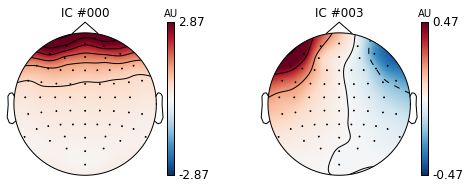

In [38]:
# check the excluded components
ica.exclude = [0,3] #7, 36, 45]
ica.plot_components(picks=ica.exclude, ch_type='eeg', title='', colorbar=True, show=True);

Using channel EXG1 as EOG channel
... filtering ICA sources
Multiple deprecated filter parameters were used:
phase in 0.13 is "zero-double" but will change to "zero" in 0.14
lower transition bandwidth in 0.13 is 0.5 Hz but will change to "auto" in 0.14
upper transition bandwidth in 0.13 is 0.5 Hz but will change to "auto" in 0.14
The default filter length in 0.13 is "10s" but will change to "auto" in 0.14


/Users/sstober/.virtualenvs/ismir/lib/python2.7/site-packages/ipykernel/__main__.py:2: DeprecationWarning: Multiple deprecated filter parameters were used:
phase in 0.13 is "zero-double" but will change to "zero" in 0.14
lower transition bandwidth in 0.13 is 0.5 Hz but will change to "auto" in 0.14
upper transition bandwidth in 0.13 is 0.5 Hz but will change to "auto" in 0.14
The default filter length in 0.13 is "10s" but will change to "auto" in 0.14
  from ipykernel import kernelapp as app


... filtering target
Multiple deprecated filter parameters were used:
phase in 0.13 is "zero-double" but will change to "zero" in 0.14
lower transition bandwidth in 0.13 is 0.5 Hz but will change to "auto" in 0.14
upper transition bandwidth in 0.13 is 0.5 Hz but will change to "auto" in 0.14
The default filter length in 0.13 is "10s" but will change to "auto" in 0.14


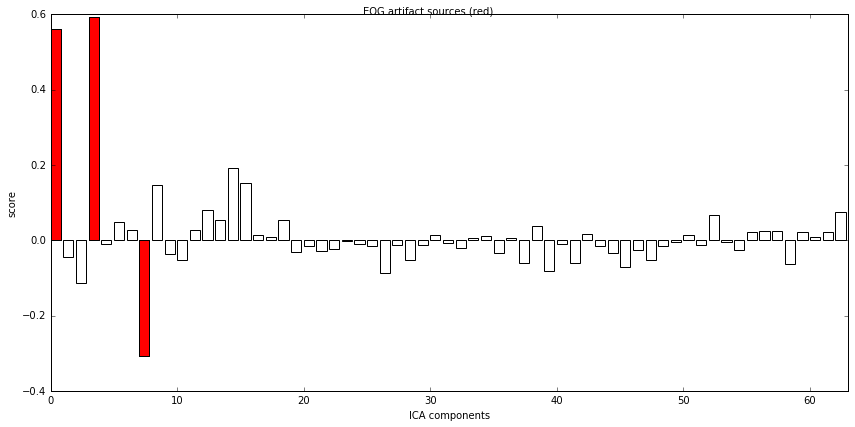

[3, 0, 7]
Disabling interactive colorbar for multiple axes. Turn interactivity on explicitly by passing cmap as a tuple.


/Users/sstober/.virtualenvs/ismir/lib/python2.7/site-packages/ipykernel/__main__.py:5: RuntimeWarning: Disabling interactive colorbar for multiple axes. Turn interactivity on explicitly by passing cmap as a tuple.


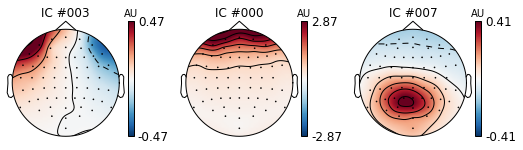

In [35]:
# auto-detect EOG channels (works similar for ECG if recorded in extra chanenl)
bad_inds, scores = ica.find_bads_eog(raw, ch_name='EXG1') # optional: specify EOG channel by name, here EXG1-4
ica.plot_scores(scores, exclude=bad_inds, title='EOG artifact sources (red)')
print bad_inds
ica.plot_components(picks=bad_inds, ch_type='eeg', title='', colorbar=True, show=True);

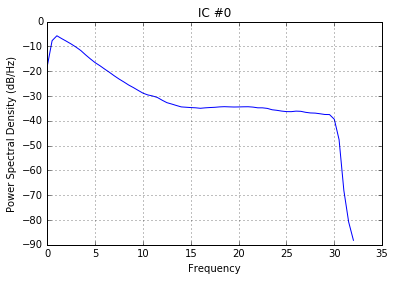

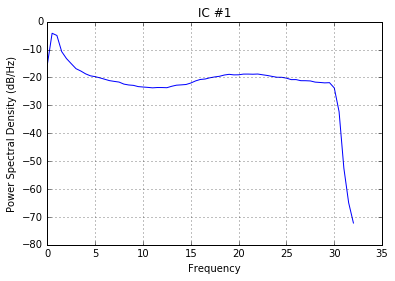

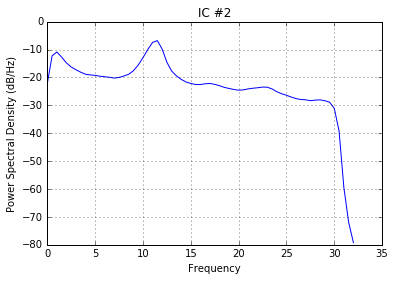

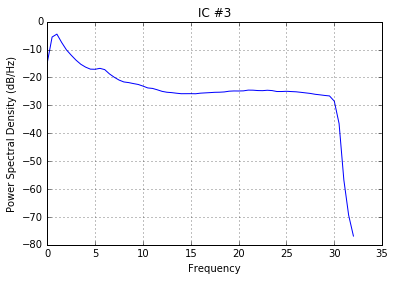

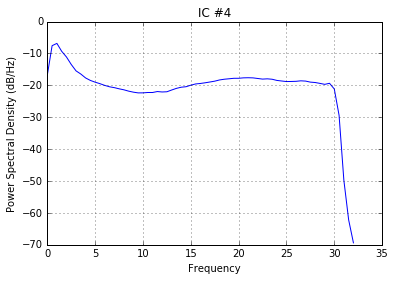

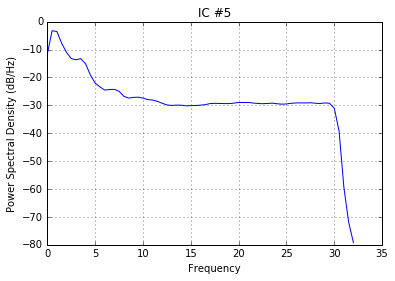

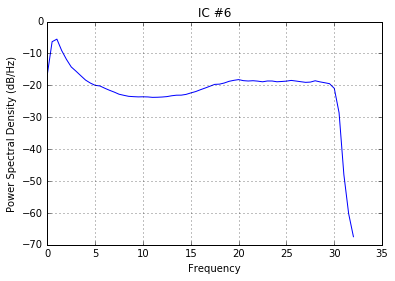

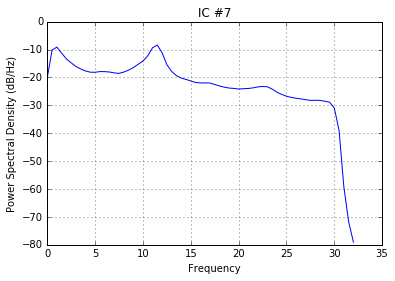

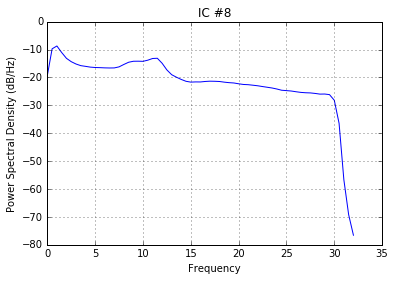

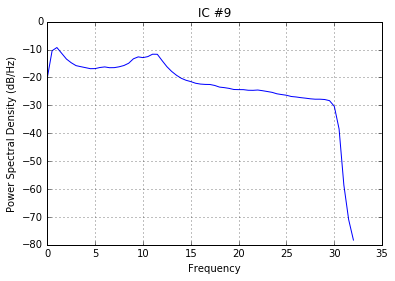

In [41]:
# this nicely reveals alpha-components
# depending on scenario, you might want to remove them, too

def inspect_source_psd(ic):
    source = ica._transform_raw(raw, 0, -1)[ic]
#     source = ica._transform_epochs(data, concatenate=True)[ic]
    sfreq = raw.info['sfreq']
    plt.figure()
    plt.title('IC #{}'.format(ic))
    plt.psd(source, Fs=sfreq, NFFT=128, noverlap=0, pad_to=None)
    plt.show()


for i in range(10):
    inspect_source_psd(i) # plot the PSD of an IC source to look for alpha activity
# inspect_source_psd(2)

In [43]:
# this shows the transformed raw data, 
# click a component to (un-)reject it
%matplotlib tk
ica.plot_sources(raw);

In [44]:
# this shows all EOG epochs concatenated and transformed, 
# click a component to (un-)reject it
%matplotlib tk
ica.plot_sources(eog_epochs);

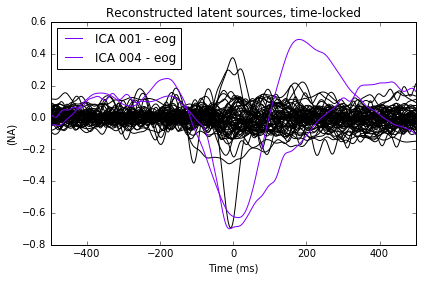

In [45]:
# Assess impact on average EOG artifact in source space
%matplotlib inline 
ica.plot_sources(eog_evoked);

Transforming to ICA space (63 components)
Zeroing out 2 ICA components


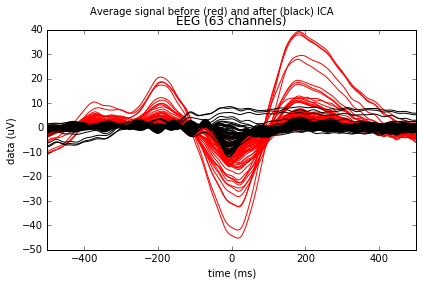

In [50]:
# Assess impact on average EOG artifact in channels
%matplotlib inline
ica.plot_overlay(eog_evoked, show=False); # show=False hack to get colors right

Transforming to ICA space (63 components)
Zeroing out 2 ICA components


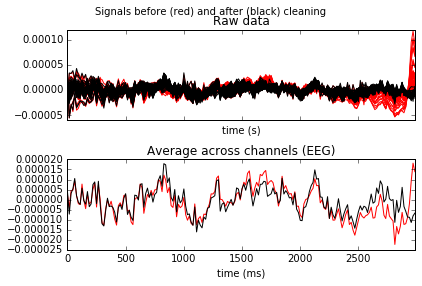

In [52]:
# Assess impact of EOG source removal on full recording
%matplotlib inline
ica.plot_overlay(raw);

In [62]:
ica.save('data/P09_cleaned-ica.fif')

Writing ica solution to data/P09_cleaned-ica.fif...


<ICA  |  raw data decomposition, fit (extended-infomax): 305070 samples, 63 components, channels used: "eeg", 2 sources marked for exclusion>

# Application Test

In [ ]:
# apply the transformation (remove excluded ICs)
raw_cleaned = ica.apply(raw, exclude=ica.exclude)

In [60]:
%matplotlib tk 

In [61]:
# the data now looks much cleaner
raw.plot();